In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split


2025-01-18 18:36:18.156518: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-18 18:36:18.173492: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-18 18:36:18.209722: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737221778.260133 2288342 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737221778.273078 2288342 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Les fichiers CSV contenant les données RSSI sont chargés dans un dictionnaire pour faciliter leur traitement. Chaque fichier est associé à une clé correspondant à son nom.

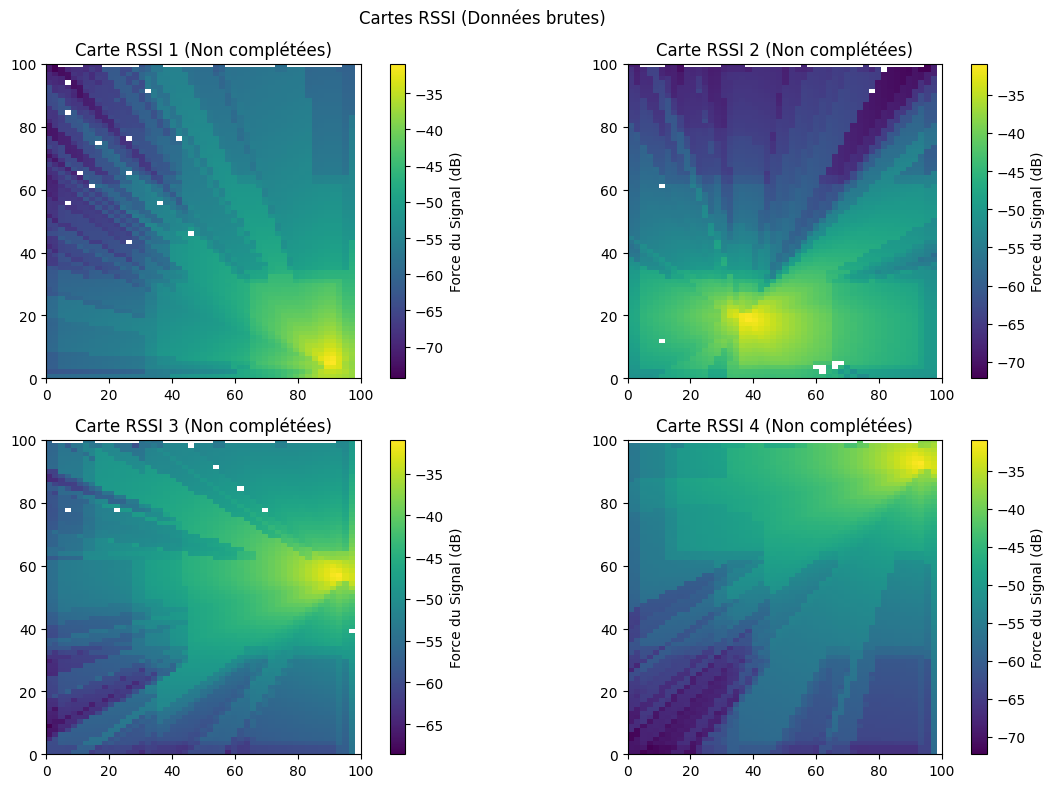

In [4]:
liste_fichiers = ["RSSI_0.csv", "RSSI_1.csv", "RSSI_2.csv", "RSSI_3.csv"]
dictionnaire_donnees = {}

for fichier in liste_fichiers:
    dictionnaire_donnees[fichier] = pd.read_csv(fichier)

# Chargement des fichiers CSV (données brutes et interpolées)
dictionnaire_donnees_brutes = {}
for fichier in liste_fichiers:
    dictionnaire_donnees_brutes[fichier] = pd.read_csv(fichier)  # Données brutes
    dictionnaire_donnees[fichier] = dictionnaire_donnees_brutes[fichier].copy()  # Préparation pour interpolation


# Fonction pour afficher les cartes RSSI
def afficher_cartes_rssi(data_dict, titre_general, interpolated=False):
    plt.figure(figsize=(12, 8))
    for index, fichier in enumerate(liste_fichiers, 1):
        plt.subplot(2, 2, index)
        plt.imshow(data_dict[fichier], cmap='viridis', origin='lower', extent=[0, 100, 0, 100])
        cbar = plt.colorbar()
        cbar.set_label('Force du Signal (dB)')
        suffixe = "(Interpolées)" if interpolated else "(Non complétées)"
        plt.title(f'Carte RSSI {index} {suffixe}')
    plt.suptitle(titre_general)
    plt.tight_layout()
    plt.show()

# Affichage des cartes RSSI avant interpolation
afficher_cartes_rssi(dictionnaire_donnees_brutes, "Cartes RSSI (Données brutes)", interpolated=False)



Les données manquantes sont interpolées à l'aide d'une méthode linéaire, à la fois ligne par ligne et colonne par colonne, pour lisser les valeurs et éviter des erreurs dues à des données incomplètes.

In [5]:
for fichier in liste_fichiers:
    dictionnaire_donnees[fichier] = dictionnaire_donnees[fichier].interpolate(method='linear', axis=0)
    dictionnaire_donnees[fichier] = dictionnaire_donnees[fichier].interpolate(method='linear', axis=1)


Les cartes RSSI interpolées sont affichées sous forme de graphiques dans une disposition en grille 2x2. Chaque graphique représente les intensités du signal pour un fichier.

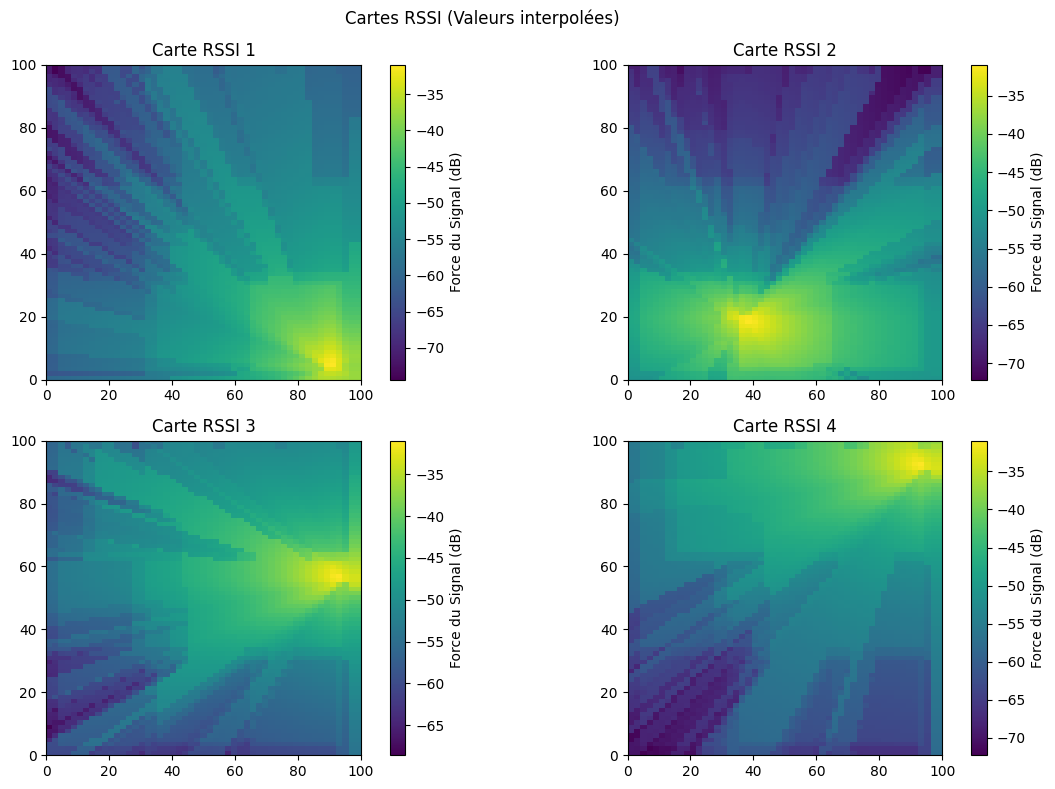

In [6]:
plt.figure(figsize=(12, 8))

for index, fichier in enumerate(liste_fichiers, 1):
    plt.subplot(2, 2, index)
    plt.imshow(dictionnaire_donnees[fichier], cmap='viridis', origin='lower', extent=[0, 100, 0, 100])
    cbar = plt.colorbar()
    cbar.set_label('Force du Signal (dB)')
    plt.title(f'Carte RSSI {index}')

plt.suptitle('Cartes RSSI (Valeurs interpolées)')
plt.tight_layout()
plt.show()


Les données RSSI sont aplaties et combinées pour former un tableau d'entrée contenant quatre caractéristiques par point. Les positions cibles associées (coordonnées réelles) sont également générées.

In [7]:
donnees_rssi_0 = dictionnaire_donnees["RSSI_0.csv"].values
donnees_rssi_1 = dictionnaire_donnees["RSSI_1.csv"].values
donnees_rssi_2 = dictionnaire_donnees["RSSI_2.csv"].values
donnees_rssi_3 = dictionnaire_donnees["RSSI_3.csv"].values

entrees_model = pd.DataFrame({
    'feature1': donnees_rssi_0.flatten(),
    'feature2': donnees_rssi_1.flatten(),
    'feature3': donnees_rssi_2.flatten(),
    'feature4': donnees_rssi_3.flatten()
})

valeurs_x, valeurs_y = np.meshgrid(np.arange(0, 51), np.arange(0, 73))
positions_reelles = pd.DataFrame({
    'coord_x': valeurs_x.flatten(),
    'coord_y': valeurs_y.flatten()
})


Un réseau neuronal est défini avec une architecture simple : une couche d'entrée, deux couches cachées utilisant la fonction ReLU, et une couche de sortie prédite pour les coordonnées ((x,y). Une métrique personnalisée R2 est également ajoutée.

In [8]:
def r2_personnalise(y_reel, y_pred):
    y_reel = tf.cast(y_reel, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    r2 = 1 - tf.reduce_sum(tf.square(y_reel - y_pred)) / tf.reduce_sum(tf.square(y_reel - tf.reduce_mean(y_reel)))
    return r2

reseau_neuronal = keras.Sequential([
    keras.layers.Input(shape=(4,)),
    keras.layers.Dense(23, activation='relu'),
    keras.layers.Dense(17, activation='relu'),
    keras.layers.Dense(2)
])

reseau_neuronal.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse', r2_personnalise])


2025-01-18 18:36:28.568930: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Les données sont divisées en ensembles d'entraînement et de validation. Le réseau neuronal est entraîné sur 500 époques pour ajuster ses paramètres et minimiser l'erreur quadratique moyenne.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(entrees_model, positions_reelles, test_size=0.2, random_state=42)

historique = reseau_neuronal.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), verbose=0)


Les courbes de perte et du coefficient R2 sont tracées pour évaluer l'entraînement et la validation du modèle au fil des époques.

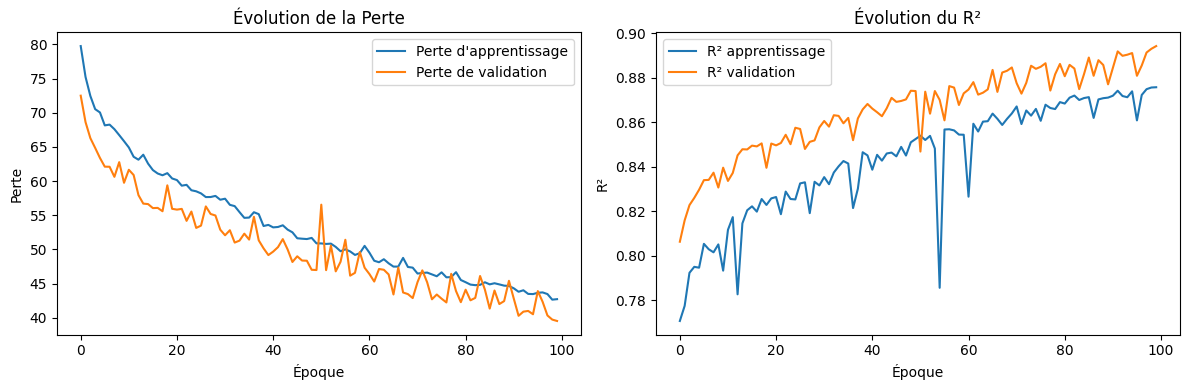

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Coefficient de détermination R² sur l'ensemble de test : 0.8513


In [14]:
perte_apprentissage = historique.history['loss']
perte_validation = historique.history['val_loss']
r2_apprentissage = historique.history['r2_personnalise']
r2_validation = historique.history['val_r2_personnalise']

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(perte_apprentissage, label='Perte d\'apprentissage')
plt.plot(perte_validation, label='Perte de validation')
plt.title('Évolution de la Perte')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(r2_apprentissage, label='R² apprentissage')
plt.plot(r2_validation, label='R² validation')
plt.title('Évolution du R²')
plt.xlabel('Époque')
plt.ylabel('R²')
plt.legend()

plt.tight_layout()
plt.show()

# Génération des prédictions pour l'ensemble de test
predictions_test = reseau_neuronal.predict(X_test)

# Calcul du R² pour l'ensemble de test
r2_test = r2_score(y_test, predictions_test)

# Affichage de la valeur du R²
print(f"Coefficient de détermination R² sur l'ensemble de test : {r2_test:.4f}")


Les distances entre les positions réelles et prédites sont calculées pour analyser les performances du modèle. Une répartition des erreurs est affichée sous forme d'histogramme.

117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


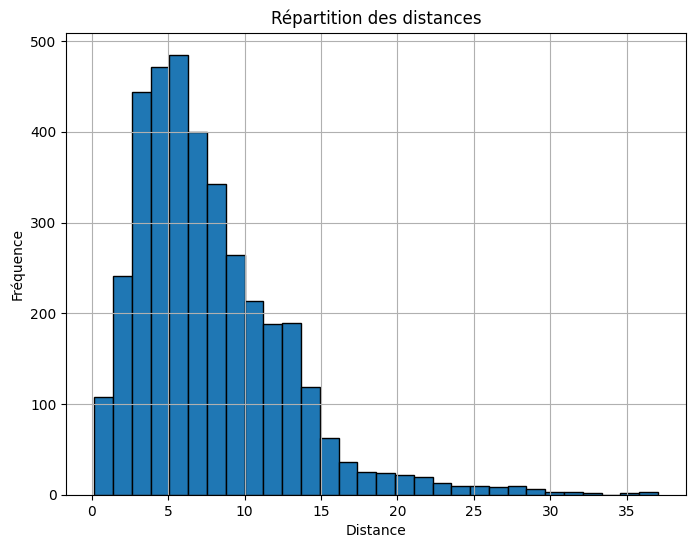

In [15]:
predictions = reseau_neuronal.predict(entrees_model)
distances_euclidiennes = np.linalg.norm(predictions - positions_reelles, axis=1)

plt.figure(figsize=(8, 6))
plt.hist(distances_euclidiennes, bins=30, edgecolor='k')
plt.title("Répartition des distances")
plt.xlabel("Distance")
plt.ylabel("Fréquence")
plt.grid(True)
plt.show()


Une carte des distances entre les positions réelles et prédites est créée pour visualiser les écarts spatiaux. Cela permet d'identifier des zones où le modèle est moins performant.

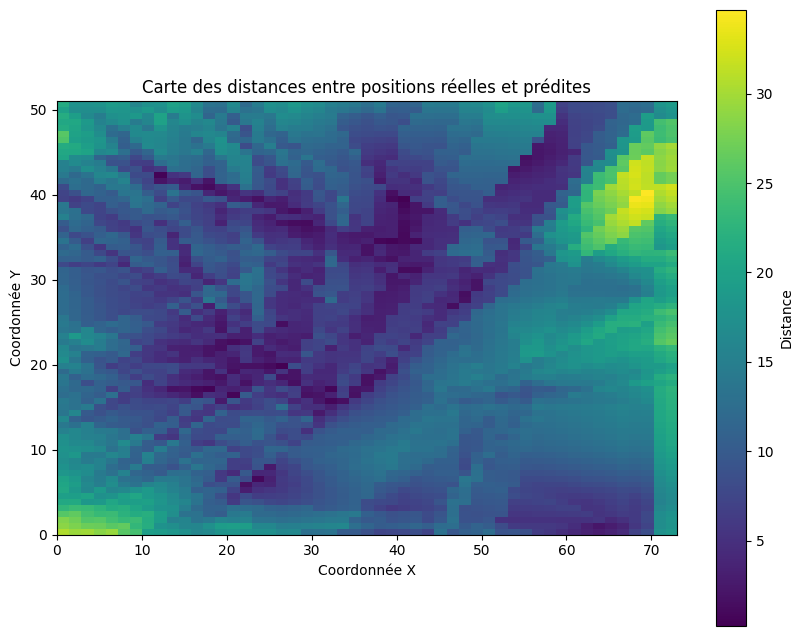

In [12]:
taille_grille = (73, 51)
carte_distances = np.zeros(taille_grille)

for x in range(taille_grille[0]):
    for y in range(taille_grille[1]):
        pos_reelle = np.array([y, x])
        pos_predite = predictions[x * taille_grille[1] + y]
        distance = np.linalg.norm(pos_reelle - pos_predite)
        carte_distances[x, y] = distance

plt.figure(figsize=(10, 8))
plt.imshow(carte_distances, cmap='viridis', origin='lower', extent=[0, taille_grille[0], 0, taille_grille[1]])
plt.colorbar(label='Distance')
plt.title('Carte des distances entre positions réelles et prédites')
plt.xlabel('Coordonnée X')
plt.ylabel('Coordonnée Y')
plt.show()
